### **Ridefinizione del Progetto**

Il progetto si evolve in una pipeline duale che combina due approcci distinti per l'elaborazione di documenti scientifici su ArXiv, uno focalizzato sull'information retrieval multimodale per il QA e l'altro orientato alla creazione e utilizzo di un grafo per il reasoning avanzato. Ecco una sintesi della nuova struttura:

---

### **1. Obiettivo Generale**
Creare un Google Colab notebook che esplora due metodi distinti:
1. **Approccio Multimodale per il QA**: Retrieval di contenuti (testo e visivi) da documenti ArXiv con valutazione quantitativa delle prestazioni su un task di multiple-choice QA.
2. **GraphRAG per Reasoning Avanzato**: Creazione e utilizzo di un grafo di conoscenza a partire da documenti ArXiv per rispondere a domande complesse (multi-hop reasoning e aggregazioni) attraverso tecnologie avanzate.

---


### **2. Descrizione dei Due Moduli**

#### **Modulo 1: Approccio Multimodale per QA**
- **Focus**: Estrarre chunk di testo e figure dai PDF, utilizzarli in pipeline di retrieval (multimodale e text-only), e valutarli quantitativamente in un task di QA multiple-choice.
- **Tecnologie**:
  - Modelli multimodali (es. ColQwen2).
  - Late interaction per text-only retrieval.
  - Metriche di valutazione come Precision@k, MRR e accuratezza downstream su QA.
- **Output**:
  - Risultati numerici sulle prestazioni dei vari approcci.
  - Tabelle e grafici comparativi.

---

#### **Modulo 2: GraphRAG per Reasoning Avanzato**
- **Focus**: Costruire un grafo di conoscenza a partire dai documenti ArXiv (estrazione di entità e relazioni) per rispondere a domande complesse.
- **Pipeline**:
  1. **Estrazione di Entità e Relazioni**:
     - Uso di LLM (es. GPT-4o-mini) per identificare nodi e archi, con varianti per aggiungere forza relazionale o descrizioni.
  2. **Popolazione del Grafo**:
     - Archiviazione in un database Neo4j per interrogazioni successive.
  3. **Interrogazione del Grafo**:
     - Approcci:
       - Vicini diretti di entità.
       - Community detection e clustering.
       - Generazione di query Cypher con un LLM.
  4. **Reasoning e Risposta**:
     - Generazione di risposte condizionate da cluster di entità.
     - Combina risposte locali e globali con pesi stimati.
- **Tecnologie**:
  - **Neo4j** per graphDB.
  - **Milvus** per indicizzazione come VectorDB.
  - **LangGraph** per pipeline automatizzata.
- **Output**:
  - Demo interattiva con domande esempio.
  - Visualizzazioni di query sul grafo e risposte.

---

## Setup

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
!pip install pillow
!pip install matplotlib
!pip install transformers torch datasets byaldi
!pip install -q pdf2image
!pip install git+https://github.com/huggingface/transformers.git
!pip install qwen-vl-utils
!pip install flash-attn
!pip install byaldi

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 21.3 MB/s eta 0:00:00
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=8fcf9b6cbdd0c6327093c5acc29b43c246b1002f414c9892431acb1a8d92529a
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-6pj9ivgk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-6pj9ivgk
  Resolved https://github.com/huggingface/transformers.git to commit 5c75087aeee7081025370e10d1f571a11600f1ae
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.9 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.48.0.dev0-py3-none-any.whl size=10328707 sha256=1345c79c614993f65c6b7fd1d780b33d4949047e45cb04457310c1389b7eb65f
  Stored in directory: /tmp/pip-ephem-wheel-cache-xmpjkyv0/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      S

In [4]:
!pip install torch torchvision

In [5]:
#!sudo apt-get install -y poppler-utils

In [6]:
!pip install ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.0/493.0 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━

In [7]:
!pip uninstall --y faiss-cpu & pip install faiss-gpu

Found existing installation: faiss-cpu 1.9.0.post1
Uninstalling faiss-cpu-1.9.0.post1:
  Successfully uninstalled faiss-cpu-1.9.0.post1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.8 MB/s eta 0:00:00


In [ ]:
!pip install seaborn

In [28]:
# Import required libraries
import os

from datasets import load_dataset

import torch
import tqdm

import requests
import re

from concurrent.futures import ThreadPoolExecutor, as_completed

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import io
import ast

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
import transformers

from byaldi import RAGMultiModalModel
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import numpy as np

from ragatouille import RAGPretrainedModel
from ragatouille.utils import get_wikipedia_page

In [9]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    PATH='/content/drive/MyDrive/MultiGraphQA/'
except:
    PATH='./'

print(PATH)

Mounted at /content/drive
/content/drive/MyDrive/MultiGraphQA/


In [10]:
# Set device
device = "mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


## Load Original Dataset

In [ ]:
"""
@misc{li2024multimodal,
            title={Multimodal ArXiv: A Dataset for Improving Scientific Comprehension of Large Vision-Language Models},
            author={Lei Li and Yuqi Wang and Runxin Xu and Peiyi Wang and Xiachong Feng and Lingpeng Kong and Qi Liu},
            year={2024},
            eprint={2403.00231},
            archivePrefix={arXiv},
            primaryClass={cs.CV}
        }
        """

# Load parquet files inside folder data
ds = load_dataset('parquet', data_files=PATH+'data/test-00000-of-00001.parquet')

# Load combined ds
# ds = load_dataset('parquet', data_files=PATH+'data/processed_images_combined.parquet')

In [ ]:
# Save all images
os.makedirs(PATH+'data/images')

for i, item in enumerate(ds['train']):
    item['image'].save(f'data/{item["image_filename"]}')

In [ ]:
ds['train'][0]

{'query': 'Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1621x1191>,
 'image_filename': 'images/1810.10511_2.jpg',
 'options': "['A. Correction causes a significant increase in surface density across all radii.', 'B. Correction results in a decrease in surface density for larger radii.', 'C. Correction causes the surface density to converge with the fspec = 1 case at larger radii.', 'D. Correction does not affect the surface density trend at all.', '-']",
 'answer': 'C',
 'page': '',
 'model': 'gpt4V',
 'prompt': '',
 'source': 'arxiv_qa'}

## Download sources pdf

In [ ]:
def download_arxiv_pdf(arxiv_id, save_path):
    url = f"https://arxiv.org/pdf/{arxiv_id}"
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"PDF downloaded successfully: {save_path}")
    else:
        raise Exception(f"Failed to download PDF. Status code: {response.status_code}")


In [ ]:


save_path = PATH + "data/docs/"
os.makedirs(save_path, exist_ok=True)

errors = []

# Funzione per scaricare un singolo PDF
def download_pdf(item):
    arxiv_id = item['image_filename'].replace('images/', '').split('_')[0]

    if not os.path.exists(f"{save_path}{arxiv_id}.pdf"):
        try:
            download_arxiv_pdf(arxiv_id, f"{save_path}{arxiv_id}.pdf")
        except Exception as e:
            try:
                arxiv_id_regex = re.compile(r'([a-z\-]+)(\d{7})')
                match = arxiv_id_regex.match(arxiv_id)
                arxiv_id = match.group(1) + '/' + match.group(2)
                download_arxiv_pdf(arxiv_id, f"{save_path}{arxiv_id}.pdf")
            except Exception:
                return arxiv_id  # Restituisce l'ID in caso di errore
    return None

# Parallelizzazione
with ThreadPoolExecutor(max_workers=8) as executor:  # Usa 8 thread (modificabile)
    future_to_item = {executor.submit(download_pdf, item): item for item in ds['train']}
    for future in as_completed(future_to_item):
        result = future.result()
        if result:
            errors.append(result)
            print(f"Failed to download PDF: {result}")

print("Download completato con errori:", errors)


Failed to download PDF: cond-mat/0603861
Failed to download PDF: 2304.04203
Failed to download PDF: quant-ph/9912091
Failed to download PDF: astro-ph/0207226
Failed to download PDF: cond-mat/0010301
Failed to download PDF: cond-mat/0201239
Failed to download PDF: cond-mat/0404614
Failed to download PDF: physics/0603179
Failed to download PDF: cs/0505008
Failed to download PDF: cond-mat/0312100
Failed to download PDF: cond-mat/0507316
Failed to download PDF: nucl-th/0408026
Failed to download PDF: cond-mat/0303467
Failed to download PDF: astro-ph/9911146
Failed to download PDF: astro-ph/0407096
Failed to download PDF: astro-ph/0302390
Failed to download PDF: cond-mat/0011289
Failed to download PDF: cond-mat/0304485
Failed to download PDF: cond-mat/0103207
Failed to download PDF: astro-ph/0309681
Failed to download PDF: cond-mat/0610297
Failed to download PDF: cond-mat/0306096
Failed to download PDF: quant-ph/0306172
Failed to download PDF: astro-ph/0007066
Failed to download PDF: 1605.0

In [ ]:
errors

['astro-ph/0207226',
 'quant-ph/9912091',
 'cond-mat/0010301',
 'cond-mat/0201239',
 'cond-mat/0404614',
 'physics/0603179',
 'cs/0505008',
 'cond-mat/0603861',
 '2304.04203',
 'cond-mat/0507316',
 'astro-ph/0407096',
 'nucl-th/0408026',
 'astro-ph/9911146',
 'cond-mat/0312100',
 'cond-mat/0303467',
 'astro-ph/0302390',
 'cond-mat/0011289',
 'cond-mat/0304485',
 'astro-ph/0309681',
 'cond-mat/0306096',
 'cond-mat/0610297',
 'cond-mat/0103207',
 'quant-ph/0306172',
 'astro-ph/0007066',
 'cond-mat/9912475',
 'cond-mat/0209400',
 'patt-sol/9807001',
 'cond-mat/0309427',
 '1605.07294',
 '2009.06919',
 '2112.01135',
 '1603.07511',
 '2211.04473',
 '2203.11482',
 '1109.0247',
 'astro-ph/0503040',
 '2109.02264',
 '2302.08063',
 'cond-mat/0305642',
 'cond-mat/0112488',
 '0806.4457',
 '1602.08753',
 '1103.0213',
 '2112.07507',
 '2001.00631',
 '1208.5149',
 '2210.17322',
 '2302.14665',
 'cond-mat/0207431',
 '1508.07972',
 '1110.0473']

In [ ]:
len(errors)

51

## Generation of images description

In [ ]:
multimodal_model_name = "Qwen/Qwen2-VL-2B-Instruct"
multimodal_model = Qwen2VLForConditionalGeneration.from_pretrained(
                                                        multimodal_model_name,
                                                        trust_remote_code=True,
                                                        torch_dtype=torch.bfloat16).to(device)
processor = AutoProcessor.from_pretrained(multimodal_model_name, trust_remote_code=True)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


In [ ]:
def create_messages(img):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": img,
                    "max_pixels": 720**2,
                },
                {
                    "type": "text",
                    "text":
                        "Based on the image, provide a detailed scientific description of the graph."
                },
            ],
        }
    ]

    return messages


In [ ]:
def invoke_generation(messages):

    print('Applying vision template...')
    # Apply a chat template to the messages without tokenizing and add a generation prompt
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    print('Tokenizing text...')
    # Process vision information from the messages to get image and video inputs
    image_inputs, video_inputs = process_vision_info(messages)

    print('Preparing inputs...')
    # Prepare the inputs for the model by combining text, images, and videos
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",  # Return the inputs as PyTorch tensors
    )

    print('Moving inputs to device...')
    # Move the inputs to the specified device (e.g., GPU)
    inputs = inputs.to(device)

    print('Generating output...')
    # Generate output IDs from the model with a maximum of 500 new tokens
    generated_ids = multimodal_model.generate(**inputs, max_new_tokens=500)

    print('Decoding output...')
    # Trim the generated IDs to remove the input IDs from the beginning
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    print('Decoding text...')
    # Decode the trimmed generated IDs to get the output text
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    print('Output:', output_text)
    print('\n\n ---------------------------------------- \n\n')
    return output_text

In [ ]:
# Function to process a single example
def process_item(example):
    try:
        img = example['image']  # Extract the image
        messages = create_messages(img)  # Create messages
        output_text = invoke_generation(messages)  # Generate output text
        return {"image_filename": example["image_filename"], "output_text": output_text}
    except Exception as e:
        print(f"Error processing item: {e}")

# Function to save processed data as a checkpoint
def save_checkpoint(processed_data, checkpoint_file):
    df = pd.DataFrame(processed_data)
    df.to_parquet(checkpoint_file, index=False)
    print(f"Checkpoint saved: {len(processed_data)} items to {checkpoint_file}")

# Process dataset in batches with checkpoints
def process_dataset_with_checkpoints(ds, batch_size=10, output_file="data/processed_images.parquet"):
    train_data = ds['train']  # Access training data
    processed_items = []  # To store processed items
    checkpoint_file = output_file

    for idx, example in enumerate(tqdm.tqdm(train_data)):
        processed_item = process_item(example)
        processed_items.append(processed_item)

        print(processed_items)

        # Save every batch_size items or at the end
        if (idx + 1) % batch_size == 0 or (idx + 1) == len(train_data):
            save_checkpoint(processed_items, checkpoint_file)

    return processed_items

# Run the processing
processed_dataset = process_dataset_with_checkpoints(
    ds, batch_size=10, output_file="data/processed_images.parquet"
)

In [ ]:
proc_img = load_dataset('parquet', data_files='data/processed_images.parquet')['train']

Generating train split: 500 examples [00:00, 128140.78 examples/s]


In [ ]:
# Join the processed data with the original dataset
df_1 = ds['train'].to_pandas()
df_2 = proc_img.to_pandas()
df = pd.merge(df_1, df_2, on="image_filename")

df.to_parquet("data/processed_images_combined.parquet", index=False)

## 1. Multimodal Representational Models with Late Interaction

https://weaviate.io/blog/late-chunking

#### Create visual embedding colqwen2-v0.1

In [ ]:
RAG = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v0.1-merged", device=device)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


In [ ]:
try:
    RAG.index(
    input_path="data/images/", # The path to your documents
    index_name='colqwen2-v0.1-merged-arxiv_qa', # The name you want to give to your index. It'll be saved at `index_root/index_name/`.
    store_collection_with_index=False, # Whether the index should store the base64 encoded documents.
    overwrite=False # Whether to overwrite an index if it already exists. If False, it'll return None and do nothing if `index_root/index_name` exists.
)
except ValueError:
    RAG=RAG.from_index('colqwen2-v0.1-merged-arxiv_qa', device='cpu')

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/Users/robertogiordano/Desktop/MultiGraphQA/.conda/lib/python3.11/site-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.indexed_embeddings.

In [ ]:
text_query = 'Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?'
results = RAG.search(text_query, k=1)
results

[{'doc_id': 245, 'page_num': 1, 'score': 24.875, 'metadata': {}, 'base64': None}]

In [ ]:
image_name='/'.join(RAG.get_doc_ids_to_file_names()[results[0]['doc_id']].split('/')[-2:])

In [ ]:
# Find image_name in ds
for i, item in enumerate(ds['train']):
    if item['image_filename']==image_name:
        break

#### Create textual embedding Ragatoutille colbert-ir/colbertv2.0

In [ ]:
ds=load_dataset('parquet', data_files=PATH+'data/processed_images.parquet')
output_text=ds['train'].to_pandas()['output_text']
output_text=output_text.apply(lambda x: x[0])
output_text=output_text.values.tolist()

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
output_text[:3]

['The graph in the image is a plot of the surface density of a hypothetical object as a function of its radius. The surface density is measured in units of \\(\\log \\Sigma [h^{-2} \\, \\text{Mpc}^{-2}]\\), where \\(h\\) is the Hubble constant. The graph has three different lines representing different scenarios:\n\n1. **Black Line (f_spec = 1)**: This line represents the surface density when the factor \\(f_{\\text{spec}}\\) is equal to 1. This line is a straight line with a negative slope, indicating that the surface density decreases as the radius increases.\n\n2. **Dashed Blue Line (f_spec ≠ 1, w/o corr.)**: This line represents the surface density when \\(f_{\\text{spec}}\\) is not equal to 1, but without any correction. This line also shows a negative slope, indicating a decrease in surface density with increasing radius.\n\n3. **Dotted Blue Line (f_spec ≠ 1, with corr.)**: This line represents the surface density when \\(f_{\\text{spec}}\\) is not equal to 1, with a correction a

In [ ]:
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [ ]:
# Generate index
RAG.index(index_name="my_index", collection=output_text, use_faiss=True)

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()




[Dec 15, 01:53:18] #> Creating directory .ragatouille/colbert/indexes/my_index 


[Dec 15, 01:53:19] [0] 		 #> Encoding 1251 passages..


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


[Dec 15, 01:53:29] [0] 		 avg_doclen_est = 150.8784942626953 	 len(local_sample) = 1,251
[Dec 15, 01:53:29] [0] 		 Creating 4,096 partitions.
[Dec 15, 01:53:29] [0] 		 *Estimated* 188,748 embeddings.
[Dec 15, 01:53:29] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/my_index/plan.json ..


/usr/local/lib/python3.10/dist-packages/colbert/indexing/collection_indexer.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sub_sample = torch.load(sub_sample_path)


[Dec 15, 01:53:32] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


[Dec 15, 01:55:09] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_s

[0.034, 0.032, 0.031, 0.029, 0.03, 0.033, 0.03, 0.03, 0.03, 0.031, 0.029, 0.031, 0.029, 0.031, 0.029, 0.032, 0.028, 0.03, 0.029, 0.029, 0.03, 0.03, 0.029, 0.029, 0.029, 0.031, 0.031, 0.032, 0.03, 0.032, 0.031, 0.033, 0.032, 0.028, 0.032, 0.029, 0.032, 0.029, 0.03, 0.034, 0.031, 0.034, 0.031, 0.032, 0.028, 0.028, 0.03, 0.035, 0.029, 0.03, 0.03, 0.029, 0.03, 0.031, 0.031, 0.03, 0.036, 0.03, 0.032, 0.029, 0.028, 0.031, 0.032, 0.031, 0.031, 0.033, 0.032, 0.031, 0.031, 0.03, 0.033, 0.03, 0.029, 0.031, 0.032, 0.033, 0.035, 0.03, 0.032, 0.034, 0.031, 0.03, 0.032, 0.033, 0.028, 0.034, 0.03, 0.031, 0.028, 0.033, 0.03, 0.032, 0.031, 0.034, 0.029, 0.031, 0.034, 0.03, 0.031, 0.03, 0.03, 0.033, 0.03, 0.031, 0.033, 0.028, 0.029, 0.029, 0.031, 0.03, 0.033, 0.033, 0.033, 0.029, 0.033, 0.03, 0.034, 0.032, 0.029, 0.032, 0.03, 0.031, 0.032, 0.033, 0.029, 0.033, 0.031, 0.031]


0it [00:00, ?it/s]

[Dec 15, 01:56:45] [0] 		 #> Encoding 1251 passages..


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
1it [00:05,  5.04s/it]
  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they 

[Dec 15, 01:56:50] #> Optimizing IVF to store map from centroids to list of pids..
[Dec 15, 01:56:50] #> Building the emb2pid mapping..
[Dec 15, 01:56:50] len(emb2pid) = 188749



100%|██████████| 4096/4096 [00:00<00:00, 56463.69it/s]

[Dec 15, 01:56:50] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt
Done indexing!


In [ ]:
query = "Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?"
RAG = RAGPretrainedModel.from_index(PATH+".ragatouille/colbert/indexes/my_index")
results = RAG.search(query, k=3)

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


Loading searcher for index my_index for the first time... This may take a few seconds
[Dec 27, 00:08:49] #> Loading codec...
[Dec 27, 00:08:49] #> Loading IVF...
[Dec 27, 00:08:49] #> Loading doclens...


/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  centroids = torch.load(centroids_path, map_loc

[Dec 27, 00:08:49] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 28.39it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2241,  2006,  1996, 10629,  1010,  2054,  2003,  1996,
         4254,  1997,  6149,  2075,  2005,  1042, 13102,  8586,  2025,  5020,
         2000,  1015,  2006,  1996,  3302,  4304,  9874,  1029,   102,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')



In [ ]:
results

[{'content': '3. **Dotted Blue Line (f_spec ≠ 1, with corr.)**: This line represents the surface density when \\(f_{\\text{spec}}\\) is not equal to 1, with a correction applied. This line has a slightly different slope compared to the dashed blue line, indicating that the correction has a small effect on the surface density.\n\nThe x-axis represents the radius in units of \\(h^{-1} \\, \\text{Mpc}\\), and the y-axis represents the surface density in units of \\(\\log \\Sigma [h^{-2} \\, \\text{Mpc}^{-2}]\\).\n\nThe graph shows that the surface density decreases as the radius increases, and the correction applied to the surface density has a small effect on the overall trend.',
  'score': 20.375,
  'rank': 1,
  'document_id': '64160ad6-a5be-42dc-8973-62c6a20a5f0d',
  'passage_id': 1},
 {'content': 'The graph in the image is a plot of the surface density of a hypothetical object as a function of its radius. The surface density is measured in units of \\(\\log \\Sigma [h^{-2} \\, \\text{

#### Create textual embedding with late chunking

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)
model = SentenceTransformer('jinaai/jina-embeddings-v2-base-en',trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/71.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert.py:   0%|          | 0.00/97.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/275M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def chunk_by_tokens(input_text: str, tokenizer: callable, chunk_size: int = 512):
    """
    Split the input text into chunks of approximately chunk_size tokens
    """
    tokens = tokenizer(input_text, return_offsets_mapping=True, add_special_tokens=False)
    token_offsets = tokens['offset_mapping']

    chunks = []
    span_annotations = []

    for i in range(0, len(token_offsets), chunk_size):
        chunk_end = min(i + chunk_size, len(token_offsets))
        if chunk_end - i > 0:
            start_offset = token_offsets[i][0]
            end_offset = token_offsets[chunk_end - 1][1]
            chunks.append(input_text[start_offset:end_offset])
            span_annotations.append((i, chunk_end))

    return chunks, span_annotations

In [ ]:
def late_chunking(
    model_output: 'BatchEncoding', span_annotation: list, max_length=None
):
    token_embeddings = model_output
    outputs = []
    for embeddings, annotations in zip(token_embeddings, span_annotation):
        if (
            max_length is not None
        ):  # remove annotations which go bejond the max-length of the model
            annotations = [
                (start, min(end, max_length - 1))
                for (start, end) in annotations
                if start < (max_length - 1)
            ]
        pooled_embeddings = [
            embeddings[start:end].sum(dim=0) / (end - start)
            for start, end in annotations
            if (end - start) >= 1
        ]
        pooled_embeddings = [
            embedding.detach().cpu().numpy() for embedding in pooled_embeddings
        ]
        outputs.append(pooled_embeddings)

    return outputs

In [ ]:
processed_images = load_dataset('parquet', data_files=PATH+'data/processed_images.parquet')

In [ ]:
def create_embeddings(text):
    # Create chunk with tokenizer
    chunks, span_annotations = chunk_by_tokens(text, tokenizer, 128)

    # Create embeddings from tokens
    token_embeddings = model.encode(text, output_value="token_embeddings").unsqueeze(0)

    # Apply late chunking
    chunk_embeddings = late_chunking(token_embeddings, [span_annotations])

    return chunks, span_annotations, chunk_embeddings

In [ ]:
cos_sim = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [ ]:
late_chunking_df = pd.DataFrame(columns = ['id', 'chunk', 'embedding'])

In [ ]:
for text in processed_images['train']:
    chunks, span_annotations, chunk_embeddings = create_embeddings(text['output_text'][0])

    for chunk, embedding in zip(chunks, chunk_embeddings[0]):
        late_chunking_df = pd.concat([late_chunking_df, pd.DataFrame({'id': text['image_filename'], 'chunk': [chunk], 'embedding': [embedding]})], ignore_index=True)

In [ ]:
late_chunking_df.to_parquet(PATH+'data/late_chunking.parquet', index=False)

In [ ]:
late_chunking_df = pd.read_parquet(PATH + 'data/late_chunking.parquet')

In [ ]:
display(ds['train'][0])
query_text = ds['train'][0]['query']
query = model.encode(query_text)
print(f"The query is: {query_text}")



{'query': 'Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1621x1191>,
 'image_filename': 'images/1810.10511_2.jpg',
 'options': "['A. Correction causes a significant increase in surface density across all radii.', 'B. Correction results in a decrease in surface density for larger radii.', 'C. Correction causes the surface density to converge with the fspec = 1 case at larger radii.', 'D. Correction does not affect the surface density trend at all.', '-']",
 'answer': 'C',
 'page': '',
 'model': 'gpt4V',
 'prompt': '',
 'source': 'arxiv_qa'}

The query is: Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?


In [ ]:
similarities = late_chunking_df['embedding'].apply(lambda x: cos_sim(query, x))

In [ ]:
similarities = similarities.sort_values(ascending=False)

In [ ]:
similarities.index[:10]

Index([3, 2, 1, 1638, 1785, 881, 1639, 657, 1786, 1043], dtype='int64')

In [ ]:
print("\nTop 3 results for Late Chunking:")

late_chunking_df.iloc[similarities.index[:3]]




Top 3 results for Late Chunking:


,id,chunk,embedding
3,images/1810.10511_2.jpg,", and the correction applied to the surface de...","[-0.33936393, -0.78576934, 0.46080622, 0.13459..."
2,images/1810.10511_2.jpg,"text{spec}}\) is not equal to 1, with a correc...","[-0.7534773, -0.8332323, 0.90532756, -0.072480..."
1,images/1810.10511_2.jpg,"is a straight line with a negative slope, indi...","[-0.86252284, -1.1321108, 0.93222845, -0.08346..."


#### RAG Pipeline Qwen

##### Retrieving

In [14]:
ds = pd.read_parquet(PATH+'data/test-00000-of-00001.parquet')

In [121]:
df_retrieved = pd.DataFrame(columns=['id_real', 'id_retrieved', 'query', 'retrieved', 'similarity', 'gold_answer'])

In [122]:
# Visual embedding late interaction
MODEL = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v0.1-merged", device=device)
MODEL = MODEL.from_index(PATH+'.byaldi/colqwen2-v0.1-merged-arxiv_qa', device=device)

for i, item in tqdm.tqdm(ds.iterrows(), total=ds.shape[0]):
    query_text = item['query']
    results = MODEL.search(query_text, k=1)
    image_name='/'.join(MODEL.get_doc_ids_to_file_names()[results[0]['doc_id']].split('/')[-2:])
    bytes_string = ds[ds['image_filename']==image_name]['image']['bytes']

    df_retrieved.loc[len(df_retrieved)] = [
        item['image_filename'],
        image_name,
        query_text,
        ds[ds['image_filename']==image_name]['image'].index,
        results[0]['score'],
        item['answer']]

    break


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.10/dist-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.indexed_embeddings.extend(torch.load(file))
  0%|          

In [123]:
df_retrieved

,id_real,id_retrieved,query,retrieved,similarity,gold_answer
0,images/1810.10511_2.jpg,images/1810.10511_2.jpg,"Based on the graph, what is the impact of corr...",0 {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\...,25.0,C


In [92]:
# Text embedding late interaction
MODEL = RAGPretrainedModel.from_index(PATH+".ragatouille/colbert/indexes/my_index")

for i, item in tqdm.tqdm(ds.iterrows(), total=ds.shape[0]):
    query_text = item['query']
    results = pd.DataFrame(MODEL.search(query_text, k=3))

    df_retrieved.loc[len(df_retrieved)] = [
        item['image_filename'],
        results['document_id'].to_list(),
        query_text,
        results['content'].to_list(),
        results['score'].to_list(),
        item['answer']]


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/500 [00:00<?, ?it/s]

Loading searcher for index my_index for the first time... This may take a few seconds
[Dec 27, 17:43:52] #> Loading codec...
[Dec 27, 17:43:52] #> Loading IVF...
[Dec 27, 17:43:52] #> Loading doclens...


/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  centroids = torch.load(centroids_path, map_loc

[Dec 27, 17:43:52] #> Loading codes and residuals...




  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2241,  2006,  1996, 10629,  1010,  2054,  2003,  1996,
         4254,  1997,  6149,  2075,  2005,  1042, 13102,  8586,  2025,  5020,
         2000,  1015,  2006,  1996,  3302,  4304,  9874,  1029,   102,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')



/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
  1%|          | 4/500 [00:02<04:42,  1.75it/s]/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.

In [93]:
# Text embedding late chunking
late_chunking_df = pd.read_parquet(PATH + 'data/late_chunking.parquet')
MODEL = SentenceTransformer('jinaai/jina-embeddings-v2-base-en',trust_remote_code=True)
cos_sim = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

for i, item in tqdm.tqdm(ds.iterrows(), total=ds.shape[0]):
    query_text = item['query']
    query = MODEL.encode(query_text)
    similarities = late_chunking_df['embedding'].apply(lambda x: cos_sim(query, x))
    similarities = similarities.sort_values(ascending=False)

    df_retrieved.loc[len(df_retrieved)] = [
        item['image_filename'],
        late_chunking_df.iloc[similarities.index[:3]]['id'].to_list(),
        query_text,
        late_chunking_df.iloc[similarities.index[:3]]['chunk'].to_list(),
        similarities[:3],
        item['answer']]

100%|██████████| 500/500 [00:20<00:00, 24.01it/s]


In [94]:
df_retrieved.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_real       1500 non-null   object
 1   id_retrieved  1500 non-null   object
 2   query         1500 non-null   object
 3   retrieved     1500 non-null   object
 4   similarity    1500 non-null   object
 5   gold_answer   1500 non-null   object
dtypes: object(6)
memory usage: 82.0+ KB


In [98]:
df_retrieved.sample(5)

,id_real,id_retrieved,query,retrieved,similarity,gold_answer
1376,images/cond-mat9912475_1.jpg,"[images/2008.09327_3.jpg, images/0807.2348_0.j...","Based on the time scales provided, which graph...","[The image presents two graphs, labeled (a) an...",247 0.840556 1571 0.834409 1572 0.83...,C
877,images/1807.07584_1.jpg,"[edd8e259-a620-4be6-b832-991cd5b5babc, 9f8c40b...",Based on the color scale at the bottom of the ...,[- **Data Points**: The data graph shows a cir...,"[21.546875, 21.09375, 20.421875]",B
844,images/2007.03109_6.jpg,"[17260484-cd4c-46ee-bfa5-60776e80996e, 504bde8...","In the rightmost figure, what does the spread ...",[The image presents three different visualizat...,"[14.171875, 13.828125, 13.671875]",D
76,images/2006.06508_1.jpg,images/2006.06508_1.jpg,"Based on the angles shown, what range of angle...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,22.625,B
1195,images/2305.04741_3.jpg,"[images/2112.13967_2.jpg, images/2112.13967_2....",What does panel (a) of the figure primarily il...,"[The image consists of three panels, labeled (...",794 0.815398 795 0.804094 894 0.79601...,C


In [97]:
df_retrieved.to_csv(PATH+'data/df_retrieved.csv', index=False)

##### Generation

In [11]:
model_name = "Qwen/Qwen2-VL-2B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(model_name,
                                                        trust_remote_code=True, torch_dtype=torch.bfloat16).to(device)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [12]:
ds = pd.read_parquet(PATH+'data/test-00000-of-00001.parquet')

In [13]:
df_retrieved = pd.read_csv(PATH+'data/df_retrieved.csv')
df_retrieved['retrieved'] = df_retrieved['retrieved'].apply(lambda x: ast.literal_eval(x))

In [14]:
df_retrieved.head()

,id_real,id_retrieved,query,retrieved,similarity,gold_answer
0,images/1810.10511_2.jpg,images/1810.10511_2.jpg,"Based on the graph, what is the impact of corr...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,25.0,C
1,images/1107.3275_2.jpg,images/1107.3275_2.jpg,"Based on the progression from JUL10 to FEB11Q,...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,24.0,D
2,images/quant-ph9912091_0.jpg,images/quant-ph9912091_0.jpg,What physical phenomenon could the pattern of ...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,18.0,B
3,images/1808.10438_2.jpg,images/1808.10438_2.jpg,What is the approximate uv-distance where the ...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,21.625,B
4,images/cond-mat0603861_2.jpg,images/cond-mat0603861_2.jpg,In which subfigures does the average arrival f...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,23.375,A


In [15]:
def create_visual_prompt(image_bytes, query, options):
    """
    Creates a visual prompt with an image and a question.

    Args:
        image_bytes (bytes): The bytes of the image.
        query (str): The question to be asked.
        options (str): The answer options.

    Returns:
        dict: A dictionary representing the visual prompt.
    """
    return [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image_bytes,
                    "max_pixels": 720**2,
                },
                {
                    "type": "text",
                    "text": (
                        f"{query}\n"
                        "Choose the correct answer from the options below: \n"
                        f"{options}\n"
                        "Answer with the letter of the correct option."
                    )
                },
            ],
        }
    ]


def create_text_prompt(context, query, options):
    """
    Creates a text-based prompt with context and a question.

    Args:
        context (str): Contextual information related to the question.
        query (str): The question to be asked.
        options (str): The answer options.

    Returns:
        dict: A dictionary representing the text-based prompt.
    """
    return [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": (
                        f"Given the following context,\n\n{context}\n\n"
                        f"Use what you think is more relevant to answer the following question: {query}\n"
                        "Choose the correct answer from the options below: \n"
                        f"{options}\n"
                        "Answer with the letter of the correct option."
                    )
                },
            ],
        }
    ]


In [16]:
def pipeline_answering(messages, model, processor):
    # Apply a chat template to the messages without tokenizing and add a generation prompt
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True)

    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(device)

    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text

In [17]:
def bytes_to_pil(byte_string):
    """
    Converts a byte string into a PIL Image.

    Args:
        byte_string (bytes or str): The byte string or encoded string.

    Returns:
        PIL.Image.Image: The PIL image object.
    """

    return Image.open(io.BytesIO(byte_string))

In [66]:
df_generated=df_retrieved.copy()

# Add a column
df_generated['generated'] = np.nan

In [ ]:
for i, item in tqdm.tqdm(df_generated.iterrows(), total=1500):

  if i<500:

    # Example Usage
    retrieved_data = item['retrieved']

    # Create visual prompt
    visual_prompt = create_visual_prompt(
        bytes_to_pil(retrieved_data),                    # Use
        item['query'],     # Query text
        ds.iloc[i]['options']                         # Options
    )


    answer = pipeline_answering(visual_prompt, model, processor)

  else:
    # Example Usage
    retrieved_data = 'CONTEXT: \n '+ '\n'.join(item['retrieved']) + '\n\nEND CONTEXT\n'

    # Create text prompt
    text_prompt = create_text_prompt(
        retrieved_data,
        item['query'],     # Query text
        ds.iloc[i%500]['options']                        # Options
    )

    answer = pipeline_answering(text_prompt, model, processor)

  print(answer,df_generated.loc[i, 'gold_answer'])

  df_generated.loc[i, 'generated']= answer


In [68]:
df_generated.to_csv(PATH+'data/df_generated.csv', index=False)

In [69]:
df_generated['generated'] = df_generated['generated'].apply(lambda x: x[0] if type(x) is list else x)

In [70]:
sum(df_generated['gold_answer'] == df_generated['generated'] )/len(df_generated )

0.4673333333333333

## Analysis

In [32]:
ds = pd.read_parquet(PATH+'data/test-00000-of-00001.parquet')

In [470]:
df_generated = pd.read_csv(PATH+'data/df_generated.csv')
df_generated['retrieved'] = df_generated['retrieved'].apply(lambda x: ast.literal_eval(x))
df_generated.loc[500:,'id_retrieved'] = df_generated.loc[500:,'id_retrieved'].apply(lambda x: ast.literal_eval(x))
df_generated.loc[1:,'generated'] = df_generated.loc[1:,'generated'].apply(lambda x: ast.literal_eval(x))
df_generated['generated'] = df_generated['generated'] \
                                            .apply(lambda x: x[0] if type(x) is list else x) \
                                            .apply(lambda x: x.replace('\n',''))   \
                                            .apply(lambda x: x.upper()
                                                                .replace(',', '')
                                                                .replace('.', '')
                                                                .replace(';', '')
                                                                .replace(':', '')
                                                                )
                                            

In [471]:
errors_gold_answer=df_generated[~df_generated['gold_answer'].isin(['A', 'B', 'C', 'D','E'])]['gold_answer']
errors_gold_answer

33                                             B) 0.1 rad
34                                    D) College football
40       B. Specific physical components of the equipment
49      C. \( N' \) increases at a constant rate as \(...
51                                               B) Biere
                              ...                        
1464                                             C. 6 meV
1471                     C. Instances of alignment errors
1479                                             B. 32 mW
1494         B) Lower value ranges occur more frequently.
1499                               B) Ar+ and He-Ne laser
Name: gold_answer, Length: 186, dtype: object

In [472]:
# Address wrong gold labels
df_generated.loc[errors_gold_answer.index, 'gold_answer'] = df_generated.loc[errors_gold_answer.index, 'gold_answer'].apply(lambda x: x[0])

In [473]:
proc_img = pd.read_parquet(PATH+'data/processed_images.parquet')
proc_img['output_text'] = proc_img['output_text'].apply(lambda x: x[0])

In [474]:
df_generated_visual = df_generated.iloc[:500][['id_real','id_retrieved','gold_answer','generated']]
df_generated_text_late_interaction = df_generated.iloc[500:1000][['id_real','retrieved','gold_answer','generated']].reset_index(drop=True)
df_generated_text_late_chunking = df_generated.iloc[1000:][['id_real','id_retrieved', 'gold_answer','generated']].reset_index(drop=True)

#### Visual

In [175]:
acc_visual_retr = sum(df_generated_visual['id_real']==df_generated_visual['id_retrieved'])/len(df_generated_visual)
print(f"Visual Late Interaction Retrieval Accuracy: {acc_visual_retr}")

Visual Late Interaction Retrieval Accuracy: 0.798


In [176]:
acc_visual_gen = sum(df_generated_visual['gold_answer']==df_generated_visual['generated'])/len(df_generated_visual)
print(f"Visual Late Interaction Generation Accuracy: {acc_visual_gen}")

Visual Late Interaction Generation Accuracy: 0.578


In [177]:
df_generated_visual['correct_retrieving'] = df_generated_visual['id_real']==df_generated_visual['id_retrieved']
df_generated_visual['correct_generating'] = df_generated_visual['gold_answer']==df_generated_visual['generated']
df_generated_visual['correct_retrieving_generating'] = df_generated_visual['correct_retrieving'] & df_generated_visual['correct_generating']

In [178]:
df_generated_visual[['correct_retrieving','correct_generating','correct_retrieving_generating']].sum()

correct_retrieving               399
correct_generating               289
correct_retrieving_generating    235
dtype: int64

In [179]:
cm = confusion_matrix(df_generated_visual['correct_retrieving'], df_generated_visual['correct_generating'])
cr=classification_report(df_generated_visual['correct_retrieving'], df_generated_visual['correct_generating'])

In [180]:
print(cr)

              precision    recall  f1-score   support

       False       0.22      0.47      0.30       101
        True       0.81      0.59      0.68       399

    accuracy                           0.56       500
   macro avg       0.52      0.53      0.49       500
weighted avg       0.69      0.56      0.61       500



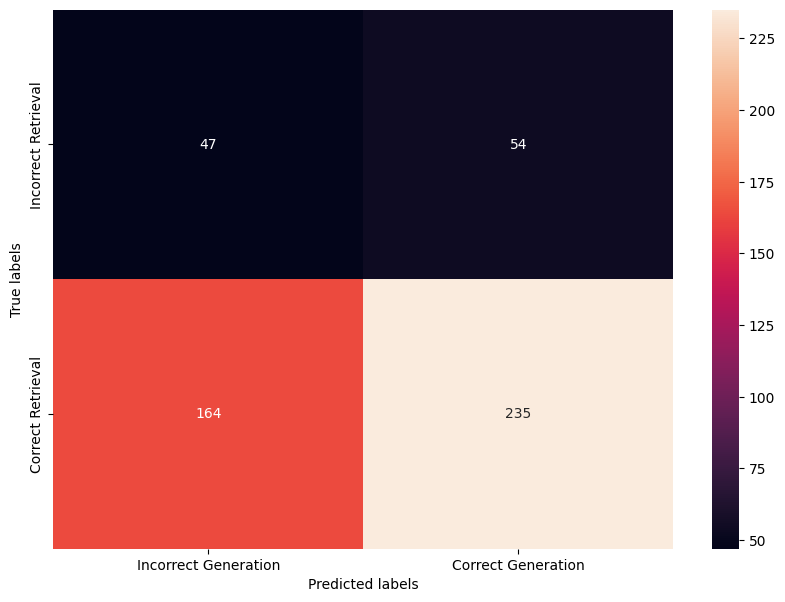

In [181]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks([0.5, 1.5], ['Incorrect Retrieval', 'Correct Retrieval'])
plt.xticks([0.5, 1.5], ['Incorrect Generation', 'Correct Generation'])
plt.show()

In [210]:
errors_generated=df_generated_visual[~df_generated_visual['generated'].isin(['A', 'B', 'C', 'D','E'])][['correct_retrieving','gold_answer','generated']]
errors_generated

,correct_retrieving,gold_answer,generated
28,True,A,C3-C4
43,True,B,['EQ (5)']
65,True,C,5
148,True,A,ROBUSTVIT W/ DINO VITB
280,True,B,2
408,True,C,THEY DO NOT INTERSECT IN THE SHOWN RANGE
420,True,B,NBA
496,True,A,STEP 3


N. 28 the answer is correct, the letter has not been retrieved

N. 43 the answer is correct, the letter has not been retrieved

N. 65 (intresting). The model understand the image, but answers the opposite question ("after how many years goes up 0.1 concentration?")

N. 148 the answer is correct, the letter has not been retrieved

N. 280 if the number refers to the order of the choice (B is the second), is correct otherwise there is no explanation on when this "2" comes from.

N. 408 the answer is wrong. The graphs interesect twice and one of them is the C answer as the gold says.

N. 420 wrong answer, really tricky to say

N. 496 wrong gold label and wrong answer. Correct answer is D.


##### Analysis on each question

In [365]:
q_ind=93

In [366]:
ds.iloc[q_ind]['query']

'Based on the graph, how does the value of \\( 10^6x_{30} \\) change with an increase in \\( 10^6x_{29} \\)?'

In [367]:
ds.iloc[q_ind]['options']

"['It decreases exponentially', 'It remains constant', 'It increases linearly', 'It increases exponentially', '-']"

In [368]:
ds.iloc[q_ind]['answer']

'C'

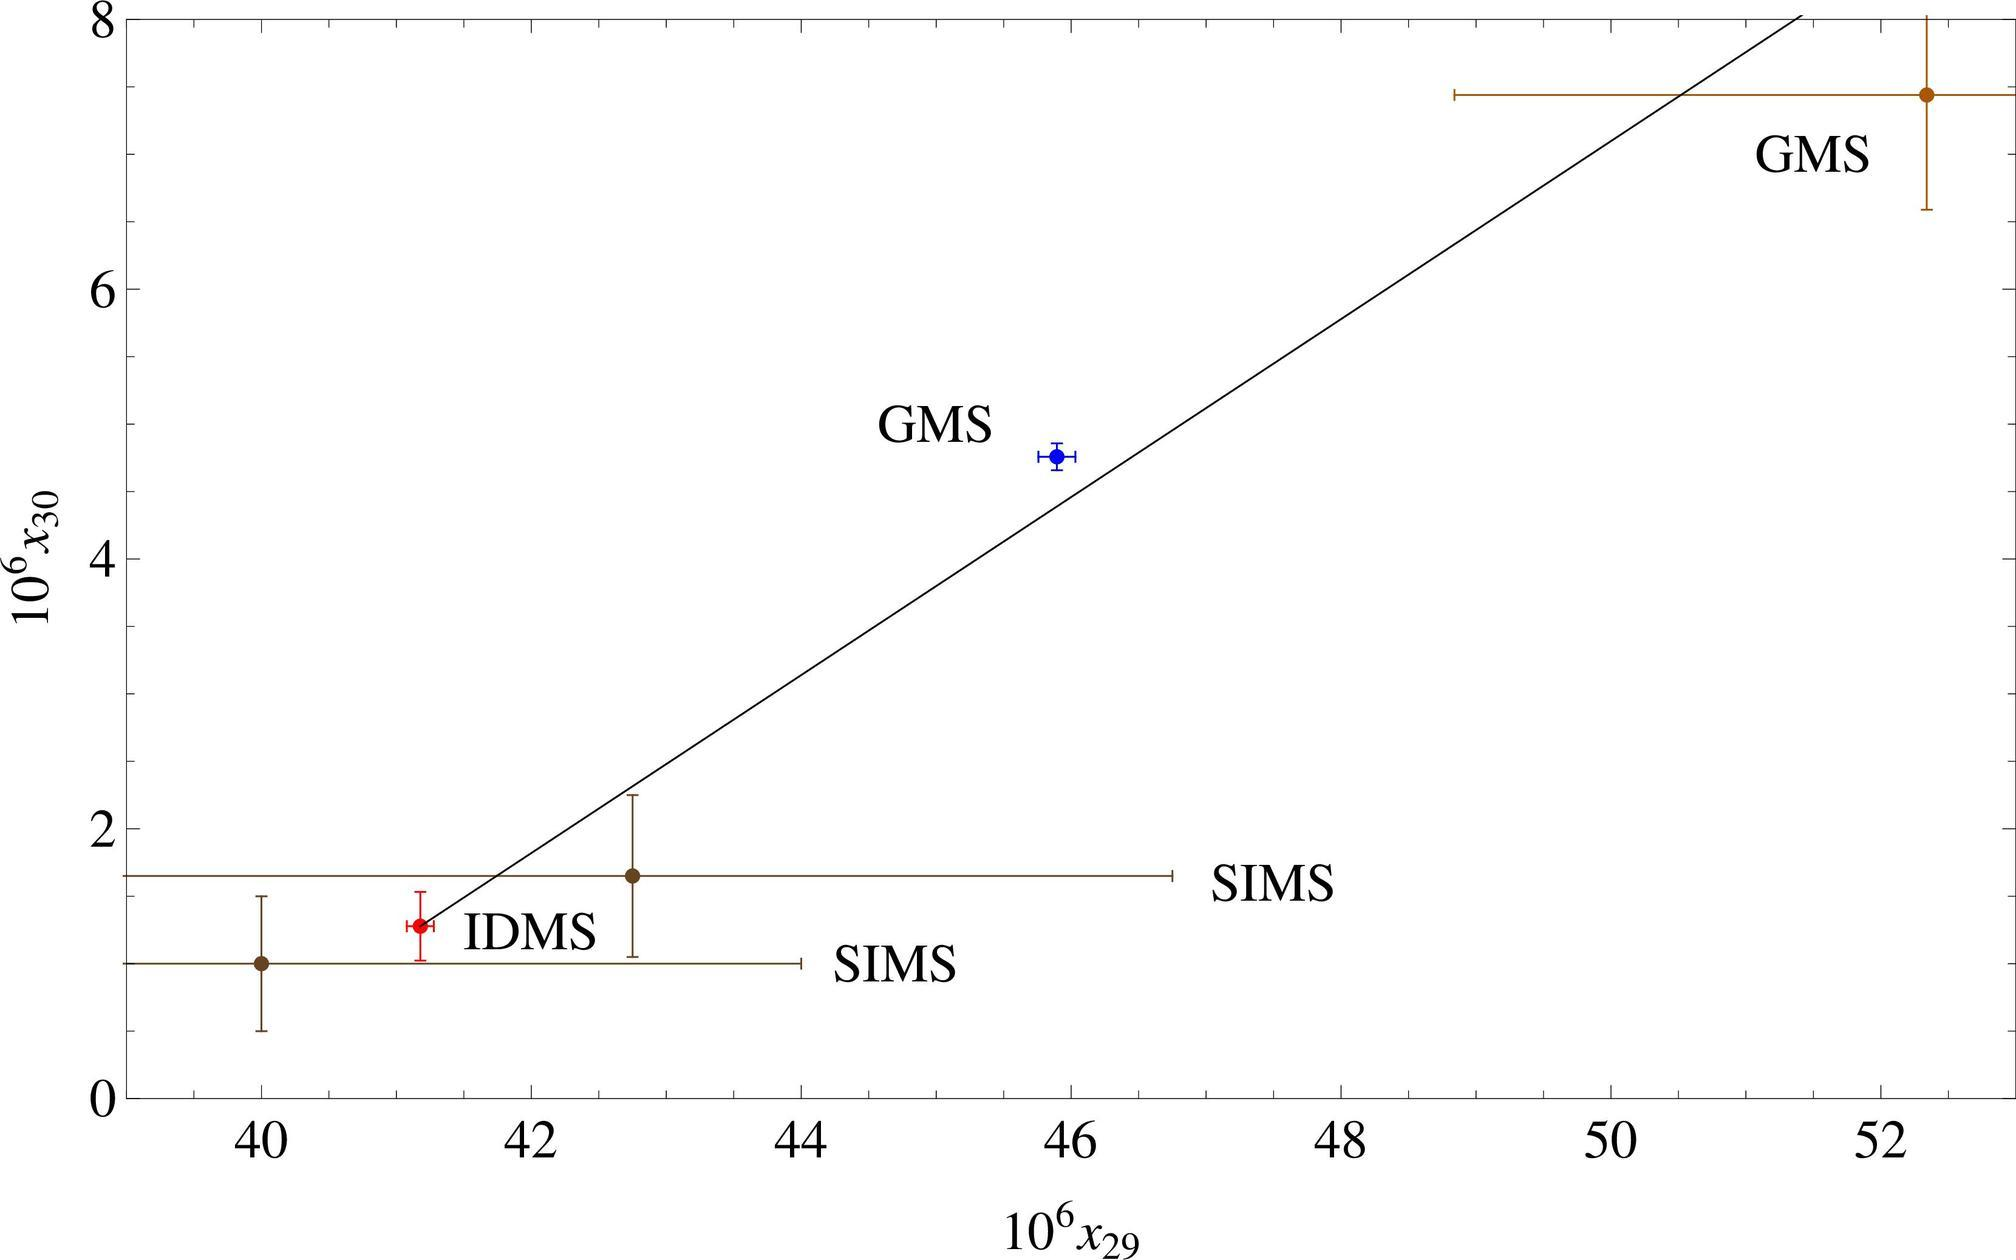

In [369]:
Image.open(io.BytesIO(ds.iloc[q_ind]['image']['bytes']))

#### Text late interaction

In [298]:
# Split the 'retrieved' column
df_generated_text_late_interaction[['retrieved_top1', 'retrieved_top2', 'retrieved_top3']] = pd.DataFrame(
    df_generated_text_late_interaction['retrieved'].tolist(), 
    index=df_generated_text_late_interaction.index
    )


In [299]:
for i, item in tqdm.tqdm(df_generated_text_late_interaction.iterrows(), total=df_generated_text_late_interaction.shape[0]):
    
    output_text = proc_img[proc_img['image_filename']==item['id_real']]['output_text'].values[0]
    df_generated_text_late_interaction.loc[i, 'retrieved_top1_check'] = True if item['retrieved_top1'] in output_text else False
    df_generated_text_late_interaction.loc[i, 'retrieved_top2_check'] = True if item['retrieved_top2'] in output_text else False
    df_generated_text_late_interaction.loc[i, 'retrieved_top3_check'] = True if item['retrieved_top3'] in output_text else False

100%|██████████| 500/500 [00:00<00:00, 4040.37it/s]


In [300]:
acc_top1 = df_generated_text_late_interaction['retrieved_top1_check'].mean()
acc_top2 = df_generated_text_late_interaction['retrieved_top2_check'].mean()
acc_top3 = df_generated_text_late_interaction['retrieved_top3_check'].mean()

at_least_one = df_generated_text_late_interaction[['retrieved_top1_check', 'retrieved_top2_check', 'retrieved_top3_check']].any(axis=1)
at_least_two = df_generated_text_late_interaction[['retrieved_top1_check', 'retrieved_top2_check', 'retrieved_top3_check']].sum(axis=1).apply(lambda x: x>=2)
all_three = df_generated_text_late_interaction[['retrieved_top1_check', 'retrieved_top2_check', 'retrieved_top3_check']].all(axis=1)

In [301]:
# Print all

print(f"Text Late Interaction Accuracy Top 1: {acc_top1}")
print(f"Text Late Interaction Accuracy Top 2: {acc_top2}")
print(f"Text Late Interaction Accuracy Top 3: {acc_top3}")
print(f"Text Late Interaction Accuracy At Least One: {at_least_one.mean()}")
print(f"Text Late Interaction Accuracy At Least Two: {at_least_two.mean()}")
print(f"Text Late Interaction Accuracy All Three: {all_three.mean()}")

Text Late Interaction Accuracy Top 1: 0.47
Text Late Interaction Accuracy Top 2: 0.362
Text Late Interaction Accuracy Top 3: 0.194
Text Late Interaction Accuracy At Least One: 0.556
Text Late Interaction Accuracy At Least Two: 0.344
Text Late Interaction Accuracy All Three: 0.126


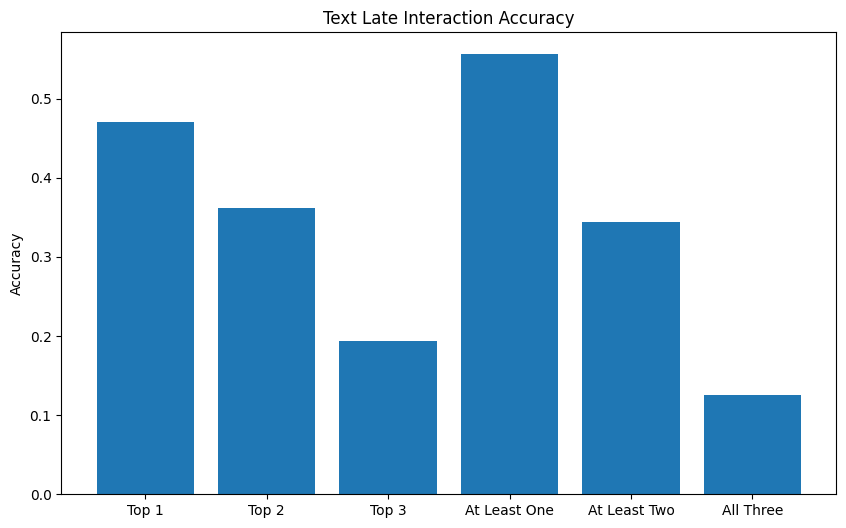

In [303]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(['Top 1', 'Top 2', 'Top 3', 'At Least One', 'At Least Two', 'All Three'], [acc_top1, acc_top2, acc_top3, at_least_one.mean(), at_least_two.mean(), all_three.mean()])
plt.ylabel('Accuracy')
plt.title('Text Late Interaction Accuracy')

# Show the plot
plt.show()

In [304]:
# Number of occurences where top 1 is false and top 2 is true
print(f"Top 1 False and Top 2 True: {df_generated_text_late_interaction[(~df_generated_text_late_interaction['retrieved_top1_check']) & df_generated_text_late_interaction['retrieved_top2_check']].shape[0]}")

# Number of occurences where top 1 is false and top 3 is true
print(f"Top 1 False and Top 3 True: {df_generated_text_late_interaction[(~df_generated_text_late_interaction['retrieved_top1_check']) & df_generated_text_late_interaction['retrieved_top3_check']].shape[0]}")

# Number of occurences where top 2 is false and top 3 is true
print(f"Top 2 False and Top 3 True: {df_generated_text_late_interaction[(~df_generated_text_late_interaction['retrieved_top2_check']) & df_generated_text_late_interaction['retrieved_top3_check']].shape[0]}")

# Number of occurences where top 1 is false and top 2 and top 3 are true
print(f"Top 1 False and Top 2 and Top 3 True: {df_generated_text_late_interaction[(~df_generated_text_late_interaction['retrieved_top1_check']) & df_generated_text_late_interaction['retrieved_top2_check'] & df_generated_text_late_interaction['retrieved_top3_check']].shape[0]}")

# Number of occurences where top 1 is false and top 2 is false and top 3 is true
print(f"Top 1 False and Top 2 False and Top 3 True: {df_generated_text_late_interaction[(~df_generated_text_late_interaction['retrieved_top1_check']) & (~df_generated_text_late_interaction['retrieved_top2_check']) & df_generated_text_late_interaction['retrieved_top3_check']].shape[0]}")

Top 1 False and Top 2 True: 26
Top 1 False and Top 3 True: 21
Top 2 False and Top 3 True: 30
Top 1 False and Top 2 and Top 3 True: 4
Top 1 False and Top 2 False and Top 3 True: 97


In [305]:
df_generated_text_late_interaction['correct_generating'] = df_generated_text_late_interaction['gold_answer']==df_generated_text_late_interaction['generated']

In [306]:
print(f"Text Late Interaction Accuracy On at least one correct retrieval and correct generation: {df_generated_text_late_interaction['correct_generating'][at_least_one].mean()}")
print(f"Text Late Interaction Accuracy On at least two correct retrieval and correct generation: {df_generated_text_late_interaction['correct_generating'][at_least_two].mean()}")
print(f"Text Late Interaction Accuracy On all three correct retrieval and correct generation: {df_generated_text_late_interaction['correct_generating'][all_three].mean()}")

Text Late Interaction Accuracy On at least one correct retrieval and correct generation: 0.5215827338129496
Text Late Interaction Accuracy On at least two correct retrieval and correct generation: 0.5465116279069767
Text Late Interaction Accuracy On all three correct retrieval and correct generation: 0.5238095238095238


In [307]:
print(f"Text Late Interaction Accuracy On Top 1 correct reetrieval correct generation: {df_generated_text_late_interaction['correct_generating'][df_generated_text_late_interaction['retrieved_top1_check']].mean()}")
print(f"Text Late Interaction Accuracy On Top 2 correct reetrieval correct generation: {df_generated_text_late_interaction['correct_generating'][df_generated_text_late_interaction['retrieved_top2_check']].mean()}")
print(f"Text Late Interaction Accuracy On Top 3 correct reetrieval correct generation: {df_generated_text_late_interaction['correct_generating'][df_generated_text_late_interaction['retrieved_top3_check']].mean()}")

Text Late Interaction Accuracy On Top 1 correct reetrieval correct generation: 0.5063829787234042
Text Late Interaction Accuracy On Top 2 correct reetrieval correct generation: 0.5524861878453039
Text Late Interaction Accuracy On Top 3 correct reetrieval correct generation: 0.5463917525773195


In [311]:
df_generated_text_late_interaction.head()

,id_real,retrieved,gold_answer,generated,retrieved_top1,retrieved_top2,retrieved_top3,retrieved_top1_check,retrieved_top2_check,retrieved_top3_check,correct_generating
0,images/1810.10511_2.jpg,"[3. **Dotted Blue Line (f_spec ≠ 1, with corr....",C,B,"3. **Dotted Blue Line (f_spec ≠ 1, with corr.)...",The graph in the image is a plot of the surfac...,This indicates that as the state rank increase...,True,True,False,False
1,images/1107.3275_2.jpg,[The image is a bar chart that compares the pe...,D,C,The image is a bar chart that compares the per...,### FEB11\n- **PO**: Approximately 0.4% of use...,The graph is a line graph that plots the perce...,True,True,False,False
2,images/quant-ph9912091_0.jpg,[### Color Gradient:\n- The color bar on the r...,B,B,### Color Gradient:\n- The color bar on the ri...,### C: Streamlines\n- The right side of the im...,### Conclusion\nThe graphs appear to represent...,False,False,False,True
3,images/1808.10438_2.jpg,[- **Blue Curve (Point Source)**: This curve r...,B,B,- **Blue Curve (Point Source)**: This curve re...,This image is a scientific graph that appears ...,"- **Y-axis (Residual, mJy)**: This axis repres...",True,True,True,True
4,images/cond-mat0603861_2.jpg,[This suggests that as the network becomes mor...,A,D,This suggests that as the network becomes more...,The image presents a comparative analysis of t...,The line is a straight line that passes throug...,True,True,True,False


In [312]:
cm = confusion_matrix(at_least_one, df_generated_text_late_interaction['correct_generating'])
cr=classification_report(at_least_one, df_generated_text_late_interaction['correct_generating'])

In [313]:
print(cr)

              precision    recall  f1-score   support

       False       0.45      0.49      0.47       222
        True       0.56      0.52      0.54       278

    accuracy                           0.51       500
   macro avg       0.50      0.50      0.50       500
weighted avg       0.51      0.51      0.51       500



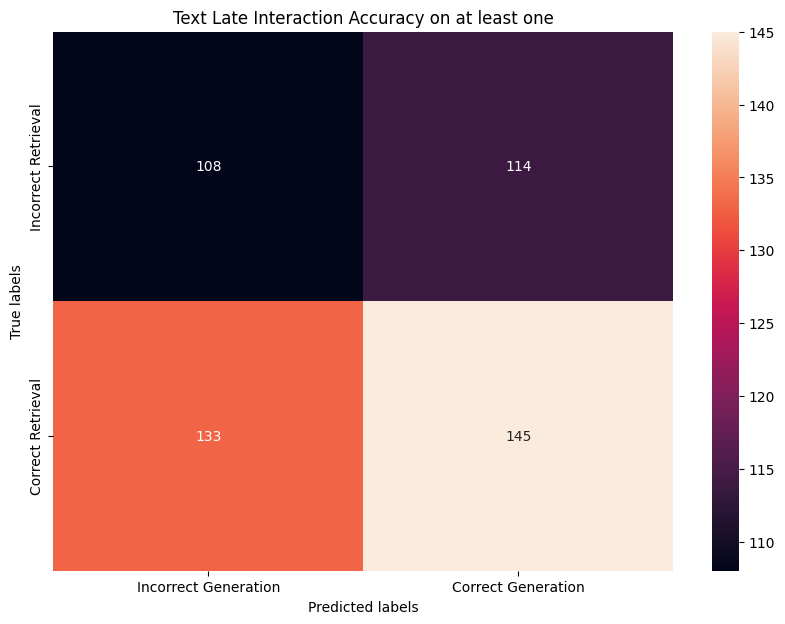

In [315]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Text Late Interaction Accuracy on at least one')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks([0.5, 1.5], ['Incorrect Retrieval', 'Correct Retrieval'])
plt.xticks([0.5, 1.5], ['Incorrect Generation', 'Correct Generation'])
plt.show()

In [309]:
errors_generated=df_generated_text_late_interaction[~df_generated_text_late_interaction['generated'].isin(['A', 'B', 'C', 'D','E'])][['gold_answer','generated']]
errors_generated

,gold_answer,generated
11,C,\\( \\DELTA(T) \\) SHOWS NON-MONOTONIC BEHAVIO...
28,A,C3-C4
43,B,EQ (5)
49,C,"[""\\( N' \\) INCREASES AT A CONSTANT RATE AS \..."
65,C,10 YEARS
79,C,01 MEV
93,C,IT INCREASES EXPONENTIALLY
132,C,0 AND Π
163,D,['THE WIDTH OF THE GREEN AREA REPRESENTING A S...
193,B,20 KILOMETERS


N. 11 wrong answer

N. 28 the answer is correct, the letter has not been retrieved

N. 43 the answer is correct, the letter has not been retrieved

N. 49 the answer is correct, the letter has not been retrieved

N. 65 wrong answer, top1 and top2 correct

N. 79 wrong answer, only top 1 correct

N. 93 wrong answer, bad retrieval

N. 132 the answer is technically correct

N. 163 wrong answer, bad retrieval

N. 193 the answer is correct, the letter has not been retrieved

N. 280 the answer is correct, the letter has not been retrieved

N. 332 wrong answer, perfect retrieval. The image details are hard to see also for human to answer the question

N. 342 wrong answer, bad retrieval

N. 407 wrong answer, bad retrieval

N. 408 wrong answer, top1 and top2 correct

N. 420 the answer is correct, the letter has not been retrieved

N. 421 wrong answer, perfect retrieval. Error in the generation of the description of the image

N. 425 the answer is correct, the letter has not been retrieved.  The retrieval is always wrong 

N. 496 right answer, top 1 retrieved good, wrong gold-answer.


##### Analysis on each question

In [451]:
q_ind=496

In [452]:
ds.iloc[q_ind]['query']

"At which step does the 'Fine-tuning' method reach its peak accuracy according to the graph?"

In [453]:
ds.iloc[q_ind]['options']

"['Step 1', 'Step 2', 'Step 3', 'Step 4']"

In [454]:
ds.iloc[q_ind]['answer']

'A'

In [455]:
df_generated_text_late_interaction.iloc[q_ind]

id_real                                           images/2210.17322_0.jpg
retrieved               [The graph is titled "Zero-shot Image Classifi...
gold_answer                                                             A
generated                                                          STEP 4
retrieved_top1          The graph is titled "Zero-shot Image Classific...
retrieved_top2          This figure illustrates the process of reducin...
retrieved_top3          This process involves using a debiased pre-tra...
retrieved_top1_check                                                 True
retrieved_top2_check                                                False
retrieved_top3_check                                                False
correct_generating                                                  False
Name: 496, dtype: object

In [456]:
for el in df_generated_text_late_interaction.iloc[q_ind]['retrieved']:
    print(el)
    print('--------------------------------')

The graph is titled "Zero-shot Image Classification," and it compares the accuracy of two different training methods: fine-tuning and joint training. The x-axis represents the number of steps, ranging from 1 to 4, while the y-axis represents the accuracy of the model in percentage.

The graph shows two lines: one for fine-tuning and one for joint training. The fine-tuning line starts at a low accuracy of approximately 5% and increases steadily with each step, reaching a maximum accuracy of around 25% after 4 steps. The joint training line starts at a higher accuracy of around 10% and also increases with each step, reaching a maximum accuracy of around 25% after 4 steps.

The graph demonstrates that joint training consistently outperforms fine-tuning in terms of accuracy, with a higher maximum accuracy and a faster increase in accuracy over the number of steps.
--------------------------------
This figure illustrates the process of reducing gender bias in BERT predictions. The figure is

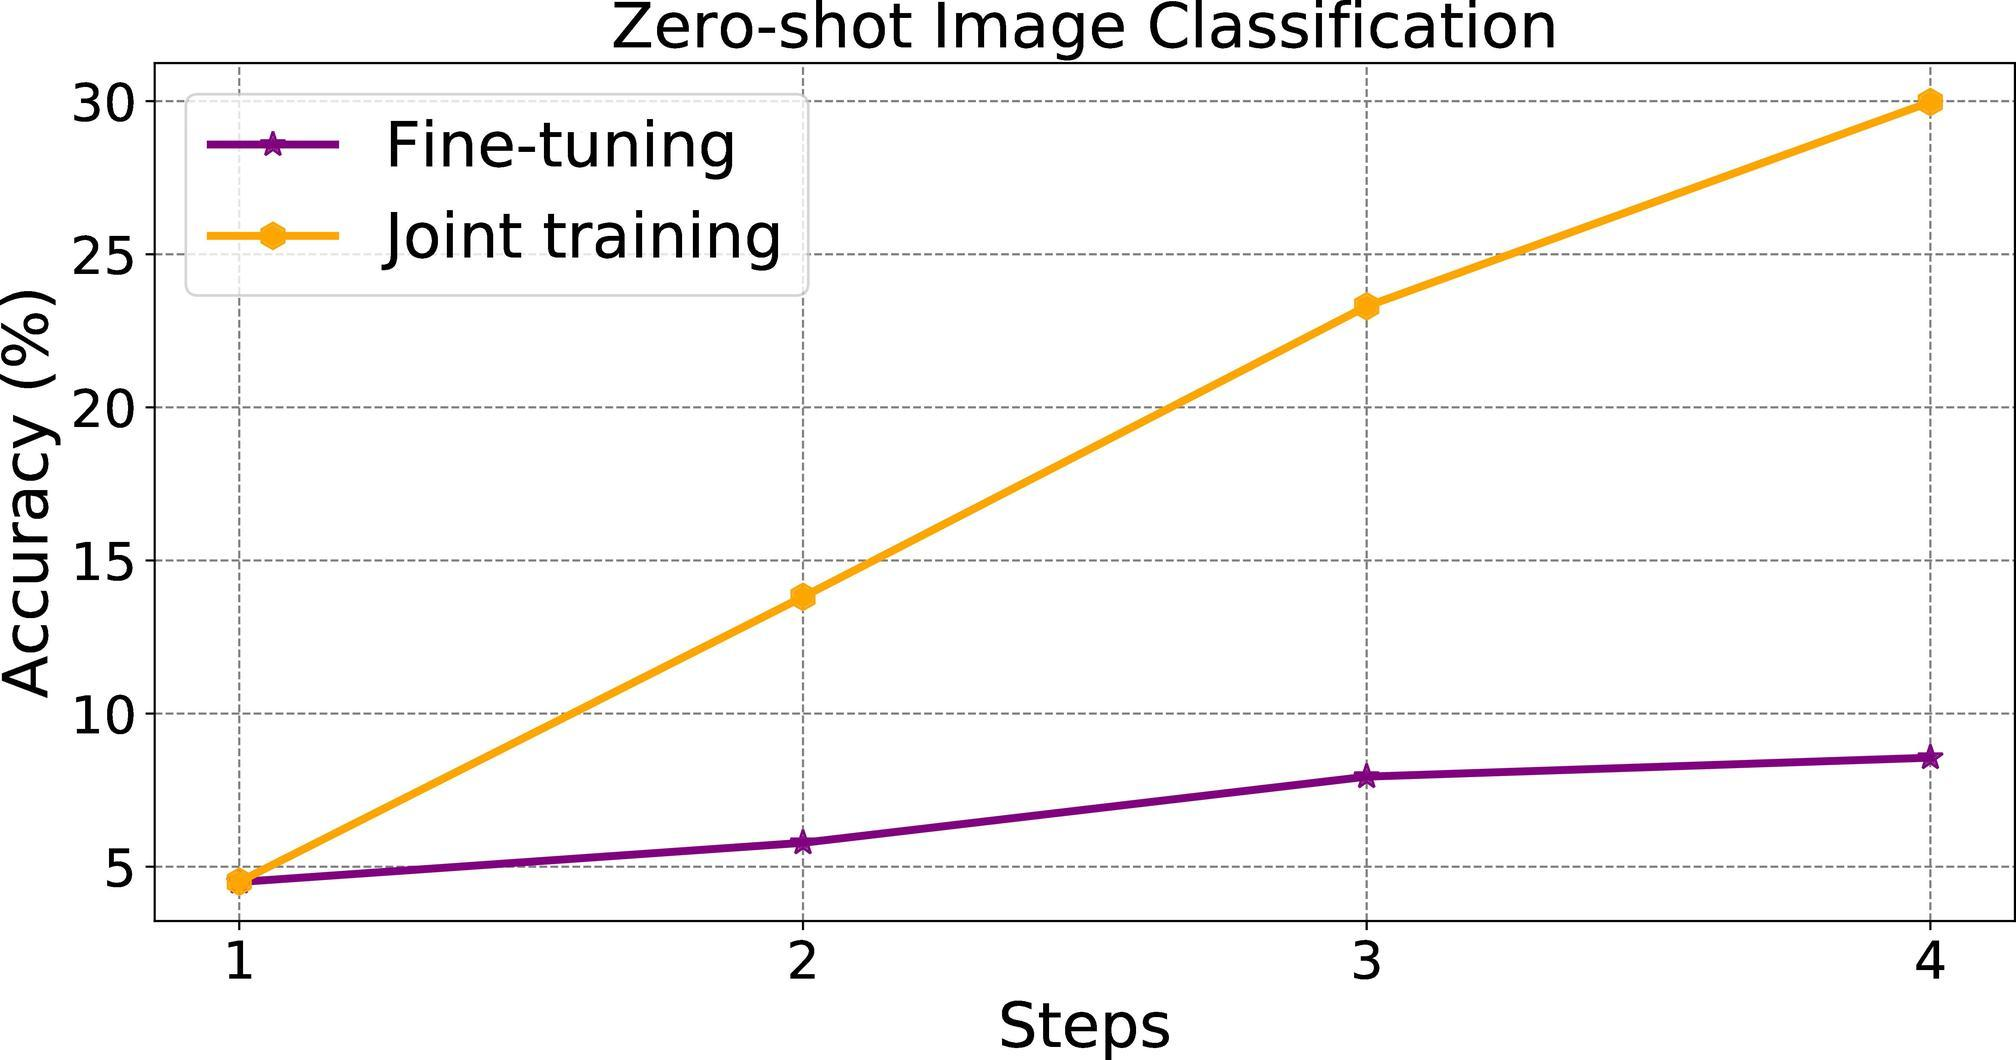

In [457]:
Image.open(io.BytesIO(ds.iloc[q_ind]['image']['bytes']))

#### Text late chunking

In [479]:
# Split the 'retrieved' column
df_generated_text_late_chunking[['id_retrieved_top1', 'id_retrieved_top2', 'id_retrieved_top3']] = pd.DataFrame(
    df_generated_text_late_chunking['id_retrieved'].tolist(), 
    index=df_generated_text_late_chunking.index
    )
df_generated_text_late_chunking['id_retrieved_top1'] = df_generated_text_late_chunking['id_retrieved_top1'] == df_generated_text_late_chunking['id_real'] 
df_generated_text_late_chunking['id_retrieved_top2'] = df_generated_text_late_chunking['id_retrieved_top2'] == df_generated_text_late_chunking['id_real']
df_generated_text_late_chunking['id_retrieved_top3'] = df_generated_text_late_chunking['id_retrieved_top3'] == df_generated_text_late_chunking['id_real']

In [481]:
acc_top1 = df_generated_text_late_chunking['id_retrieved_top1'].mean()
acc_top2 = df_generated_text_late_chunking['id_retrieved_top2'].mean()
acc_top3 = df_generated_text_late_chunking['id_retrieved_top3'].mean()

at_least_one = df_generated_text_late_chunking[['id_retrieved_top1', 'id_retrieved_top2', 'id_retrieved_top3']].any(axis=1)
at_least_two = df_generated_text_late_chunking[['id_retrieved_top1', 'id_retrieved_top2', 'id_retrieved_top3']].sum(axis=1).apply(lambda x: x>=2)
all_three = df_generated_text_late_chunking[['id_retrieved_top1', 'id_retrieved_top2', 'id_retrieved_top3']].all(axis=1)

In [482]:
# Print all

print(f"Text Late Interaction Accuracy Top 1: {acc_top1}")
print(f"Text Late Interaction Accuracy Top 2: {acc_top2}")
print(f"Text Late Interaction Accuracy Top 3: {acc_top3}")
print(f"Text Late Interaction Accuracy At Least One: {at_least_one.mean()}")
print(f"Text Late Interaction Accuracy At Least Two: {at_least_two.mean()}")
print(f"Text Late Interaction Accuracy All Three: {all_three.mean()}")

Text Late Interaction Accuracy Top 1: 0.422
Text Late Interaction Accuracy Top 2: 0.354
Text Late Interaction Accuracy Top 3: 0.288
Text Late Interaction Accuracy At Least One: 0.478
Text Late Interaction Accuracy At Least Two: 0.372
Text Late Interaction Accuracy All Three: 0.214


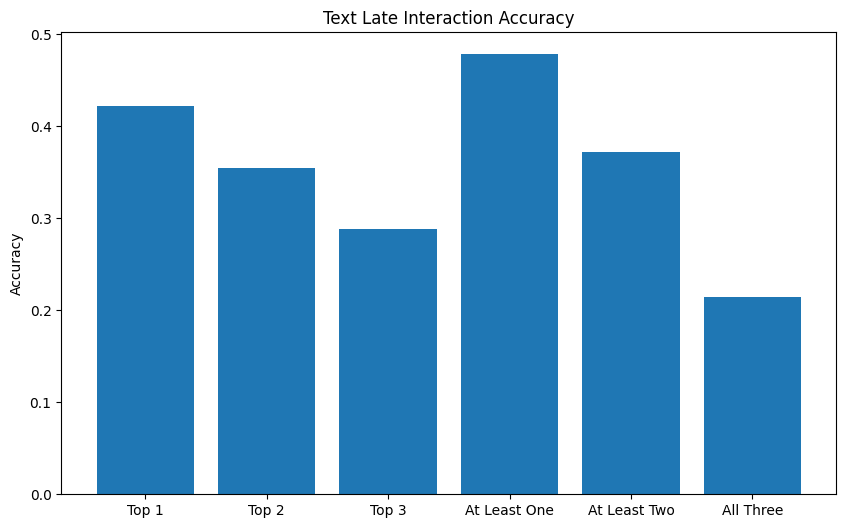

In [483]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(['Top 1', 'Top 2', 'Top 3', 'At Least One', 'At Least Two', 'All Three'], [acc_top1, acc_top2, acc_top3, at_least_one.mean(), at_least_two.mean(), all_three.mean()])
plt.ylabel('Accuracy')
plt.title('Text Late Interaction Accuracy')

# Show the plot
plt.show()

In [485]:
# Number of occurences where top 1 is false and top 2 is true
print(f"Top 1 False and Top 2 True: {df_generated_text_late_chunking[(~df_generated_text_late_chunking['id_retrieved_top1']) & df_generated_text_late_chunking['id_retrieved_top2']].shape[0]}")

# Number of occurences where top 1 is false and top 3 is true
print(f"Top 1 False and Top 3 True: {df_generated_text_late_chunking[(~df_generated_text_late_chunking['id_retrieved_top1']) & df_generated_text_late_chunking['id_retrieved_top3']].shape[0]}")

# Number of occurences where top 2 is false and top 3 is true
print(f"Top 2 False and Top 3 True: {df_generated_text_late_chunking[(~df_generated_text_late_chunking['id_retrieved_top2']) & df_generated_text_late_chunking['id_retrieved_top3']].shape[0]}")

# Number of occurences where top 1 is false and top 2 and top 3 are true
print(f"Top 1 False and Top 2 and Top 3 True: {df_generated_text_late_chunking[(~df_generated_text_late_chunking['id_retrieved_top1']) & df_generated_text_late_chunking['id_retrieved_top2'] & df_generated_text_late_chunking['id_retrieved_top3']].shape[0]}")

# Number of occurences where top 1 is false and top 2 is false and top 3 is true
print(f"Top 1 False and Top 2 False and Top 3 True: {df_generated_text_late_chunking[(~df_generated_text_late_chunking['id_retrieved_top1']) & (~df_generated_text_late_chunking['id_retrieved_top2']) & df_generated_text_late_chunking['id_retrieved_top3']].shape[0]}")

Top 1 False and Top 2 True: 17
Top 1 False and Top 3 True: 18
Top 2 False and Top 3 True: 30
Top 1 False and Top 2 and Top 3 True: 7
Top 1 False and Top 2 False and Top 3 True: 11


In [486]:
df_generated_text_late_chunking['correct_generating'] = df_generated_text_late_chunking['gold_answer']==df_generated_text_late_chunking['generated']

In [487]:
print(f"Text Late Interaction Accuracy On at least one correct retrieval and correct generation: {df_generated_text_late_chunking['correct_generating'][at_least_one].mean()}")
print(f"Text Late Interaction Accuracy On at least two correct retrieval and correct generation: {df_generated_text_late_chunking['correct_generating'][at_least_two].mean()}")
print(f"Text Late Interaction Accuracy On all three correct retrieval and correct generation: {df_generated_text_late_chunking['correct_generating'][all_three].mean()}")

Text Late Interaction Accuracy On at least one correct retrieval and correct generation: 0.49372384937238495
Text Late Interaction Accuracy On at least two correct retrieval and correct generation: 0.46774193548387094
Text Late Interaction Accuracy On all three correct retrieval and correct generation: 0.4672897196261682


In [488]:
print(f"Text Late Interaction Accuracy On Top 1 correct reetrieval correct generation: {df_generated_text_late_chunking['correct_generating'][df_generated_text_late_chunking['id_retrieved_top1']].mean()}")
print(f"Text Late Interaction Accuracy On Top 2 correct reetrieval correct generation: {df_generated_text_late_chunking['correct_generating'][df_generated_text_late_chunking['id_retrieved_top2']].mean()}")
print(f"Text Late Interaction Accuracy On Top 3 correct reetrieval correct generation: {df_generated_text_late_chunking['correct_generating'][df_generated_text_late_chunking['id_retrieved_top3']].mean()}")

Text Late Interaction Accuracy On Top 1 correct reetrieval correct generation: 0.5023696682464455
Text Late Interaction Accuracy On Top 2 correct reetrieval correct generation: 0.4576271186440678
Text Late Interaction Accuracy On Top 3 correct reetrieval correct generation: 0.4722222222222222


In [489]:
df_generated_text_late_chunking.head()

,id_real,id_retrieved,gold_answer,generated,id_retrieved_top1,id_retrieved_top2,id_retrieved_top3,correct_generating
0,images/1810.10511_2.jpg,"[images/1810.10511_2.jpg, images/1810.10511_2....",C,B,True,True,True,False
1,images/1107.3275_2.jpg,"[images/1107.3275_2.jpg, images/1212.2055_0.jp...",D,D,True,False,True,True
2,images/quant-ph9912091_0.jpg,"[images/0902.0400_3.jpg, images/1806.05299_2.j...",B,B,False,False,False,True
3,images/1808.10438_2.jpg,"[images/1808.10438_2.jpg, images/1808.10438_2....",B,B,True,True,False,True
4,images/cond-mat0603861_2.jpg,"[images/cond-mat0603861_2.jpg, images/cond-mat...",A,D,True,True,True,False


In [490]:
cm = confusion_matrix(at_least_one, df_generated_text_late_chunking['correct_generating'])
cr=classification_report(at_least_one, df_generated_text_late_chunking['correct_generating'])

In [491]:
print(cr)

              precision    recall  f1-score   support

       False       0.54      0.54      0.54       261
        True       0.50      0.49      0.49       239

    accuracy                           0.52       500
   macro avg       0.52      0.52      0.52       500
weighted avg       0.52      0.52      0.52       500



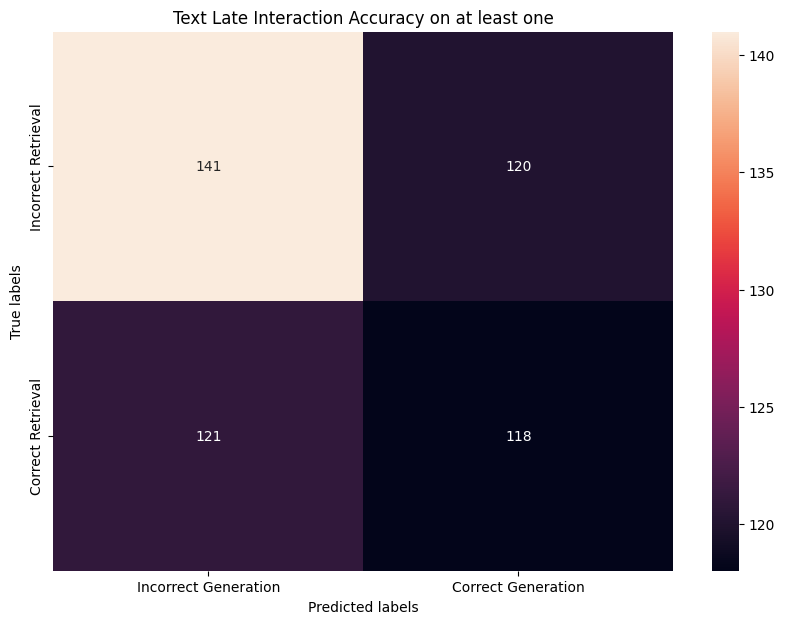

In [492]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Text Late Interaction Accuracy on at least one')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks([0.5, 1.5], ['Incorrect Retrieval', 'Correct Retrieval'])
plt.xticks([0.5, 1.5], ['Incorrect Generation', 'Correct Generation'])
plt.show()

In [494]:
errors_generated=df_generated_text_late_chunking[~df_generated_text_late_chunking['generated'].isin(['A', 'B', 'C', 'D','E'])][['gold_answer','generated']]
errors_generated

,gold_answer,generated
11,C,\\( \\DELTA(T) \\) SHOWS NON-MONOTONIC BEHAVIO...
28,A,C3-C4
43,B,'EQ (5)'
49,C,"[""\\( N' \\) INCREASES AT A CONSTANT RATE AS \..."
65,C,10 YEARS
79,C,01 MEV
93,C,IT INCREASES EXPONENTIALLY
132,C,0 AND Π
146,D,D) THE FIGURE DOES NOT PROVIDE INFORMATION ABO...
148,A,ROBUSTVIT W/ DINO VITB


N. 11 wrong answer, bad retrieval

N. 28 the answer is correct, the letter has not been retrieved

N. 43 the answer is correct, the letter has not been retrieved

N. 49 the answer is correct, the letter has not been retrieved

N. 65 wrong answer, all retrieving correct. The generatioin of the description is not accurate as it should be and does not contain the answer.

N. 79 wrong answer, bad retrieval

N. 93 wrong answer, bad retrieval

N. 132 the answer is technically correct

N. 146 the answer is correct, the letter has not been retrieved

N. 148 the answer is correct, the letter has not been retrieved

N. 159 wrong answer, bad retrieval

N. 163 wrong answer, bad retrieval

N. 193 the answer is correct, the letter has not been retrieved

N. 246 wrong answer, bad retrieval

N. 280 the answer is correct, the letter has not been retrieved

N. 318 wrong answer, top1 and top2 correct. From the description could be difficult to infer the right answer

N. 326 wrong answer, perfect retrieval. The answer is correct if we analyze the description of the image, is hard to infer from that.

N. 332 wrong answer, perfect retrieval. The image details are hard to see also for human to answer the question

N. 342 wrong answer, bad retrieval

N. 363 the answer is correct, the letter has not been retrieved

N. 364 the answer is correct, the letter has not been retrieved

N. 407 wrong answer, only top2 correct. The description does not provide enough information.

N. 408 wrong answer, perfect retrieval

N. 420 wrong answer, perfect retrieval

N. 421 wrong answer, perfect retrieval. Error in the generation of the description of the image

N. 425 wrong answer, bad retrieval

N. 496 right answer, top 1 retrieved good, wrong gold-answer.


##### Analysis on each question

In [641]:
q_ind=496

In [642]:
ds.iloc[q_ind]['query']

"At which step does the 'Fine-tuning' method reach its peak accuracy according to the graph?"

In [643]:
ds.iloc[q_ind]['options']

"['Step 1', 'Step 2', 'Step 3', 'Step 4']"

In [644]:
ds.iloc[q_ind]['answer']

'A'

In [645]:
df_generated_text_late_chunking.iloc[q_ind]

id_real                                         images/2210.17322_0.jpg
id_retrieved          [images/2210.17322_0.jpg, images/2210.17322_0....
gold_answer                                                           A
generated                                                        STEP 4
id_retrieved_top1                                                  True
id_retrieved_top2                                                  True
id_retrieved_top3                                                 False
correct_generating                                                False
Name: 496, dtype: object

In [646]:
for el in df_generated_text_late_interaction.iloc[q_ind]['retrieved']:
    print(el)
    print('--------------------------------')

The graph is titled "Zero-shot Image Classification," and it compares the accuracy of two different training methods: fine-tuning and joint training. The x-axis represents the number of steps, ranging from 1 to 4, while the y-axis represents the accuracy of the model in percentage.

The graph shows two lines: one for fine-tuning and one for joint training. The fine-tuning line starts at a low accuracy of approximately 5% and increases steadily with each step, reaching a maximum accuracy of around 25% after 4 steps. The joint training line starts at a higher accuracy of around 10% and also increases with each step, reaching a maximum accuracy of around 25% after 4 steps.

The graph demonstrates that joint training consistently outperforms fine-tuning in terms of accuracy, with a higher maximum accuracy and a faster increase in accuracy over the number of steps.
--------------------------------
This figure illustrates the process of reducing gender bias in BERT predictions. The figure is

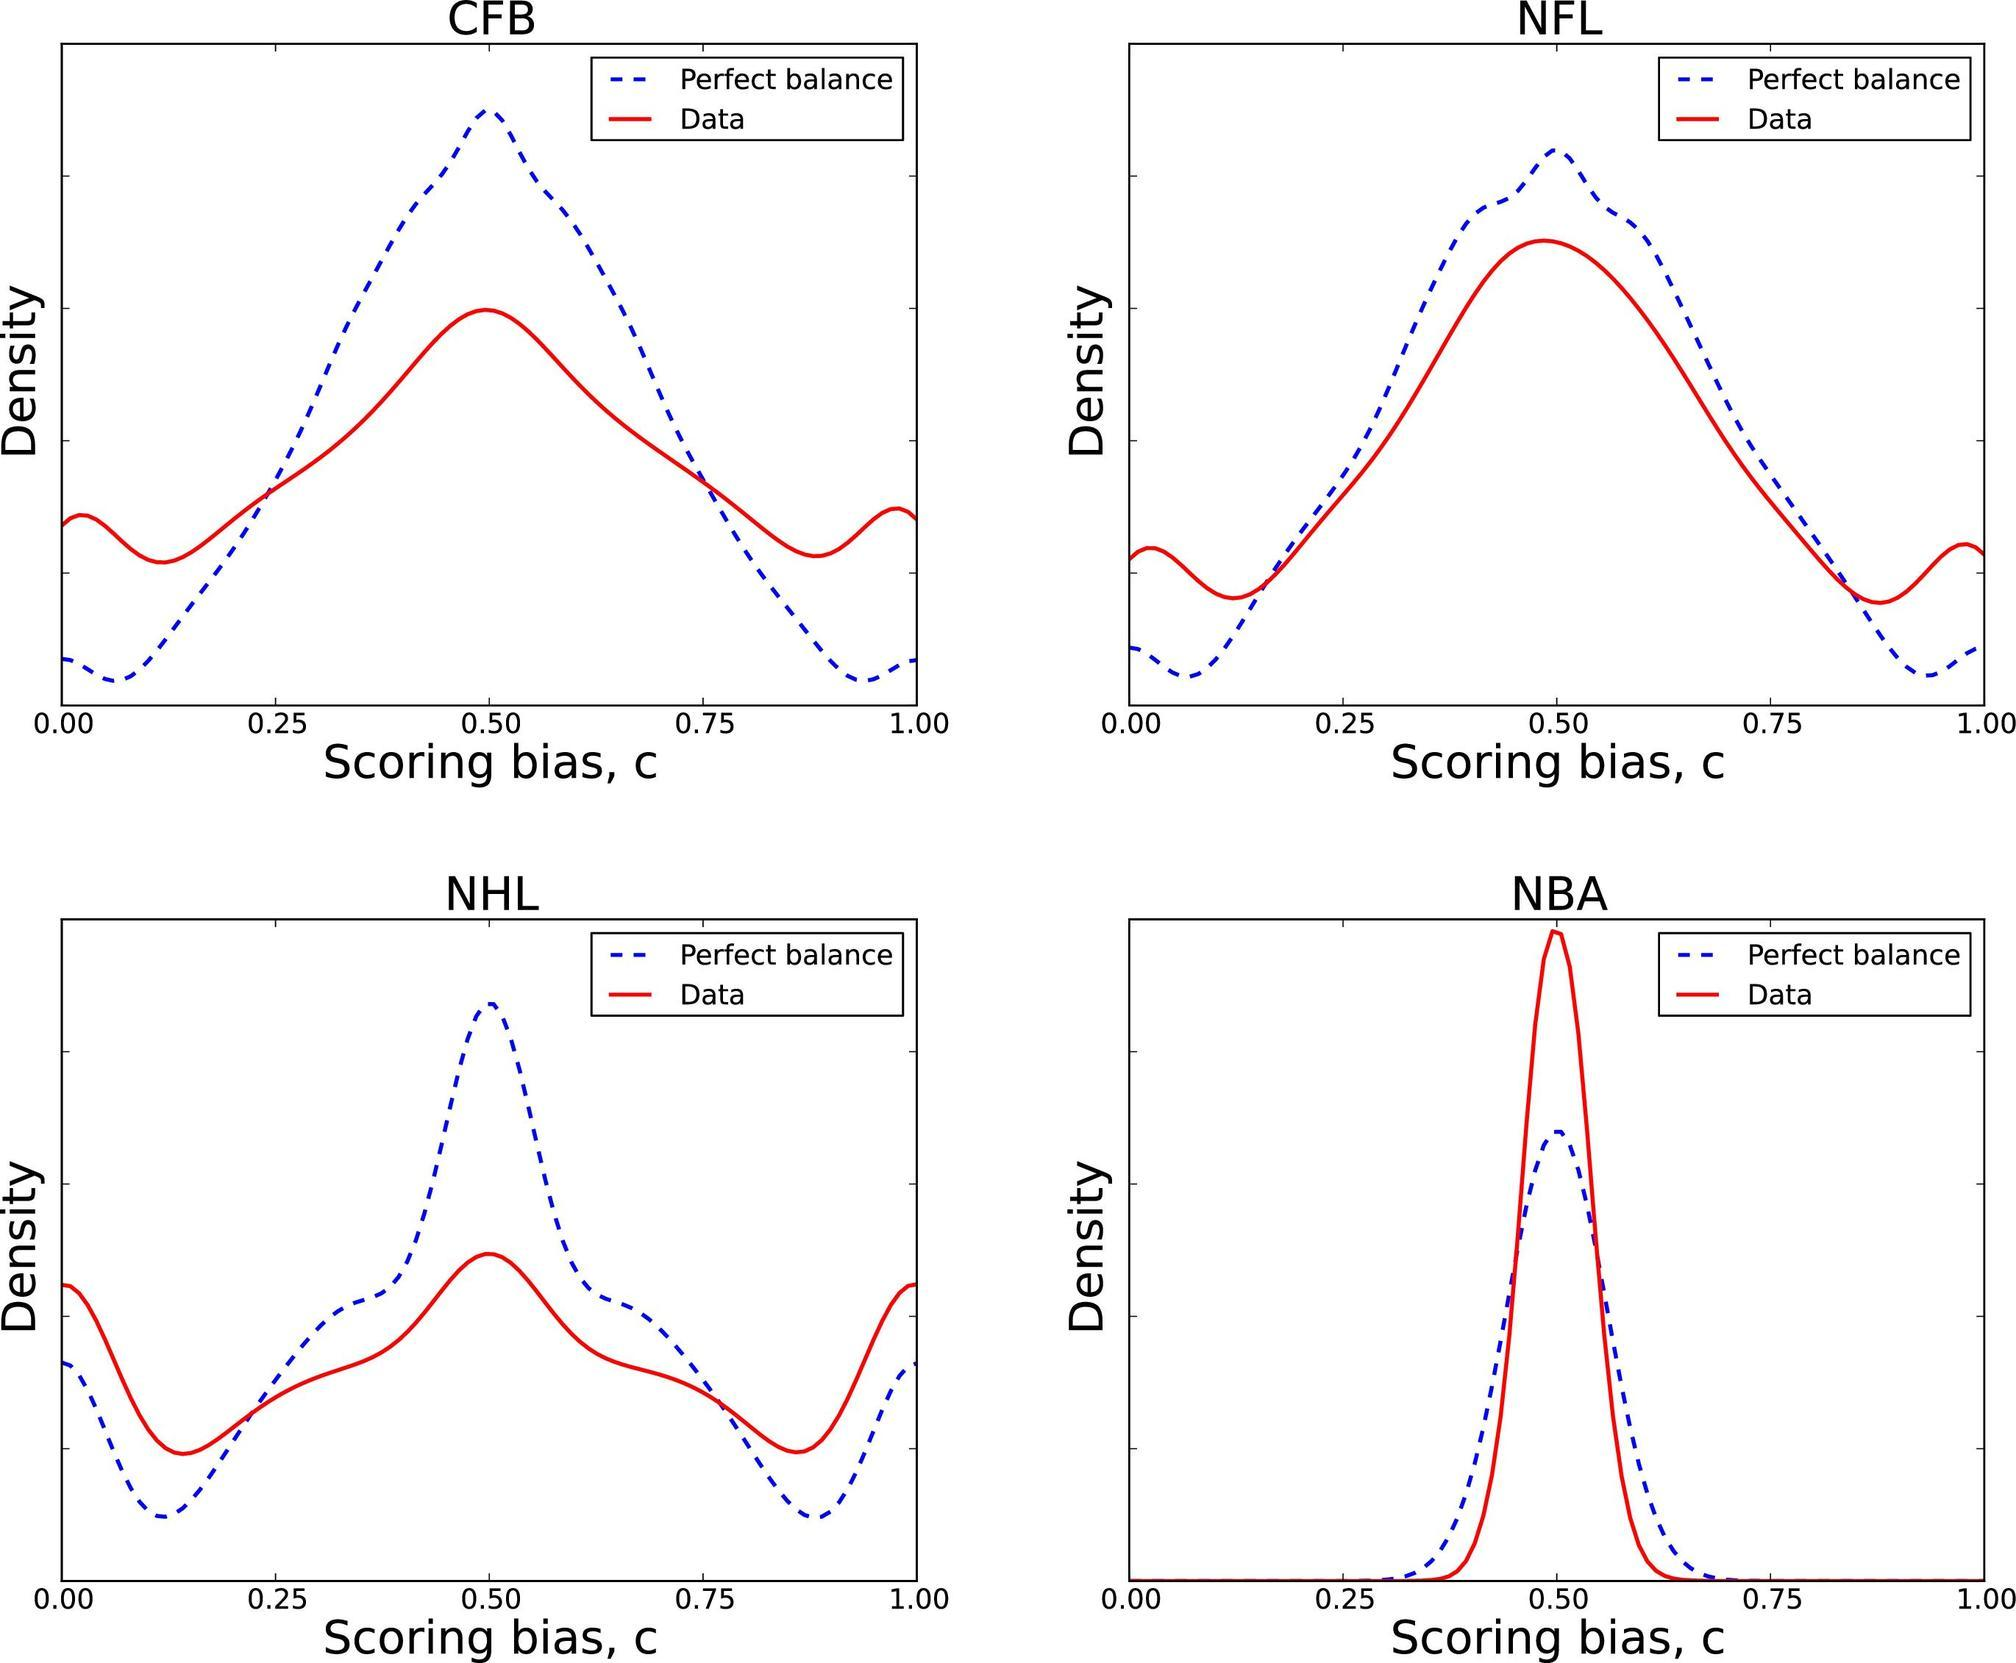

In [629]:
Image.open(io.BytesIO(ds.iloc[q_ind]['image']['bytes']))

#### RAG pipeline Gemma

In [ ]:
# model_id = "google/gemma-2-2b-it"
model_id = "models/gemma-2-2b-it"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device=device
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


In [ ]:
messages = [
    {"role": "user", "content": "Who are you? Please, answer in pirate-speak."},
]

outputs = pipeline(messages, max_new_tokens=256)
assistant_response = outputs[0]["generated_text"][-1]["content"].strip()
print(assistant_response)
# Ahoy, matey! I be Gemma, a digital scallywag, a language-slingin' parrot of the digital seas. I be here to help ye with yer wordy woes, answer yer questions, and spin ye yarns of the digital world.  So, what be yer pleasure, eh? 🦜

Ahoy, matey! I be Gemma, a digital scallywag, a language-slingin' parrot of the digital seas.  I be here to help ye with yer wordy woes, answer yer questions, and spin ye yarns of the digital world.  So, what be yer pleasure, eh? 🦜


#### **Parte 1: Multimodal Retrieval**


3. **Implementazione Approcci**:
   - Multimodale con modelli avanzati.
   - Text-only con late interaction e late chunking.

4. **Pipeline di QA**: Risoluzione multiple-choice con un modello generativo.

5. **Valutazione**:
   - Metriche di retrieval.
   - Accuratezza su QA.

6. **Visualizzazione**: Risultati e grafici comparativi.

#### **Parte 2: GraphRAG**
1. **Setup**: Installazione librerie (Neo4j, Milvus, LangGraph).
2. **Estrazione Triple**:
   - LLM per nodi e archi.
   - Scelta tra aggiunta di forza relazionale o descrizioni.
3. **Costruzione del Grafo**:
   - Inserimento in Neo4j.
4. **Interrogazione e Reasoning**:
   - Community detection, vicini diretti, query Cypher.
   - Generazione risposte locali e globali.
5. **Demo Interattiva**:
   - Domande multi-hop con risposte strutturate.
6. **Visualizzazione**:
   - Visualizzazione del grafo e delle risposte.

---


### **4. Output Finale**
- **Modulo 1**: Report quantitativo sulle prestazioni dei modelli di retrieval nel task multimodale.
- **Modulo 2**: Grafo di conoscenza interattivo con risposte a domande complessive e reasoning complesso.